In [2]:
#Required Dependencies

!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=166f1e814883b6e4fe6510a629f3eafe9c5292cdf5922d72d533fed6dbd9e8df
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=cdeb8a06b7cb01b95cb736ab064ecfc4147818e074fcfa46db42ac6b9f99b5a1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate


from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256) # Dimensions for Images


torch.cuda.is_available() # Checks if CUDA (NVIDIA parallel computing architecture) is available.

True

In [6]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        # Path of images and masks from the dataset and the length of the images
        
        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        
        # Transformations done to each image
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')

        # Converts images to NumPy arrays for further processing

        img,mask=np.array(img),np.array(mask)

        # Applies transformation on the images

        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        # Transposes the image and mask array and normalizes pixel values to the range [0, 1]

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

    def __len__(self):
        return self.len

In [8]:
# For Google Collab

#X = sorted(glob.glob('/content/WaterBodiesDataset/Images/*'))
#y = sorted(glob.glob('/content/WaterBodiesDataset/Masks/*'))

# For Running Locally
X = sorted(glob.glob('/kaggle/input/dataset/WaterBodiesDataset/Images/*'))
y = sorted(glob.glob('/kaggle/input/dataset/WaterBodiesDataset/Masks/*'))

In [9]:
# Number of masks in the array
len(y)

2841

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

# New Section

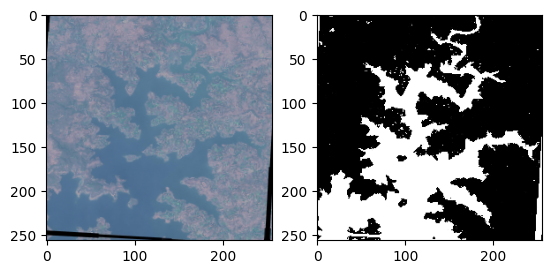

In [12]:
#  Retrieves a single sample from the training dataset using index 18.
img, mask = train_dataset[18]

# Creates a subplot with two axes
# Displays the mask image in the second axis, squeezing the mask tensor to remove singleton dimensions and using grayscale colormap.
# Displays the input image in the first axis after transposing the image tensor to the correct format for visualization.

f, axarr = plt.subplots(1,2)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [13]:
DEVICE='cuda' # Specifies that the device for training will be GPU ('cuda'). If not available, you might want to change it to 'cpu'.

EPOCHS=15 #  An epoch is one complete pass through the entire training dataset.
BATCH_SIZE=32 # The batch size of 32 means that the model will update its weights after processing 32 samples.
LR=0.001 # The learning rate determines the size of the steps taken during optimization. A smaller learning rate may lead to slower but more stable training.

ratio=0.5 # Pixels with predicted values greater than this ratio will be considered part of the water body.
sample_num=18 # Specifies the index of the sample from the dataset that will be used for visualization during evaluation.

ENCODER='resnet50' # Specifies the encoder architecture for the U-Net model.
WEIGHTS='imagenet' # Specifies the weight initialization for the encoder. 'imagenet' indicates that pre-trained weights from ImageNet will be used.

In [14]:
# DataLoader is a PyTorch class that provides an iterable over a dataset. It loads batches of data in parallel during training.
# Difference b/w train and valid loader is shuffle, shuffle is false in valid_loader as it goal is to evaluate model against unseen data

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [15]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [16]:
# This class will serve as the architecture for your segmentation model.

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    
    # This method defines the forward pass of the model.
    
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks) # Calculates the Dice loss for binary segmentation.
            loss2=nn.BCEWithLogitsLoss()(logits,masks) # Calculates the Binary Cross-Entropy loss with logits.
            return logits,loss1,loss2
        return logits
    
# A Dice coefficient of 1 indicates a perfect match between the predicted and ground truth masks, while a coefficient of 0 indicates no overlap.

In [17]:
# Creates an instance of the SegmentationModel class and moves the model to the specified device (either GPU or CPU)

model=SegmentationModel()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s] 


SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [18]:
# This function is a training loop for your segmentation model

def train_fn(data_loader,model,optimizer):
    # Sets the model in training mode. This is important because certain layers, like dropout and batch normalization, behave differently during training compared to evaluation.
    model.train()

    total_diceloss = 0.0
    total_bceloss = 0.0

    for images ,masks in tqdm(data_loader):
        # Ensures that all images and masks are of the same data type

        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        # Clears the gradients of all optimized tensors. This is necessary before computing the gradients for a new batch.

        optimizer.zero_grad()

        # Logits refer to the raw, un-normalized predictions that a model generates for each class.
        logits,diceloss,bceloss=model(images,masks) # Calls forward method to compute the diceloss and bceloss.
        diceloss.backward(retain_graph=True) # Computes the gradients of the loss with respect to the model parameters.
        bceloss.backward()
        optimizer.step() # Updates the model parameters using the computed gradients and the specified optimization algorithm.
        
        total_diceloss += diceloss.item()
        total_bceloss += bceloss.item()

    # Returns the average Dice loss and Binary Cross-Entropy loss over all batches in the data loader.
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [19]:
def eval_fn(data_loader,model):
    # Sets the model in evaluation mode. This is important because certain layers, like dropout and batch normalization, behave differently during training compared to evaluation.
    model.eval()
    
    total_diceloss = 0.0
    total_bceloss = 0.0
    
    # torch.no_grad() is a context manager provided by PyTorch that allows you to perform operations without computing gradients.

    with torch.no_grad():
        for images ,masks in tqdm(data_loader):

            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)

            total_diceloss += diceloss.item()
            total_bceloss += bceloss.item()

        # Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader)) # Gets the next batch of data from the validation loader.
            image=image[sample_num]
            mask=mask[sample_num]

            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0)) # Passes the input image through the model to obtain logits for the segmentation mask.

            # Applies the sigmoid activation function to the logits to obtain predicted probabilities and converts it into binary predictions by thresholding with the specified ratio.

            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio) * 1.0

            # Creates a subplot with three images: the ground truth mask (axarr[1]), the original image (axarr[0]), and the predicted mask (axarr[2]).

            f, axarr = plt.subplots(1,3)
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [20]:
# Choose b/w Stochastic Gradient Descent OR ADAM optimizer

optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
# torch.optim.Adam(model.parameters(),lr=LR)

100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


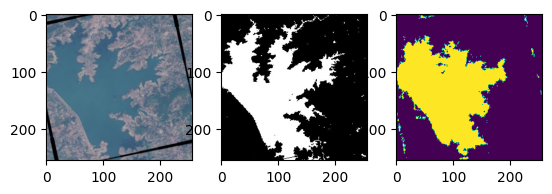

Epochs:1
Train_loss --> Dice: 0.44009683430194857 BCE: 0.47231753803789617 
Valid_loss --> Dice: 0.3397503164079454 BCE: 0.3835844463772244
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


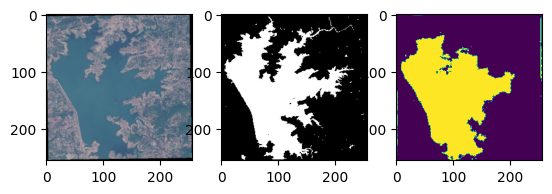

Epochs:2
Train_loss --> Dice: 0.3109632022678852 BCE: 0.36511425487697124 
Valid_loss --> Dice: 0.2818370196554396 BCE: 0.32197941177421147
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


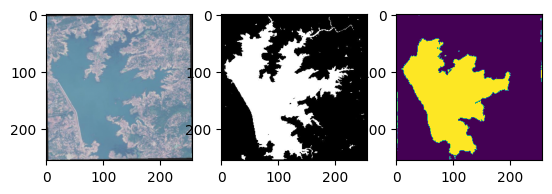

Epochs:3
Train_loss --> Dice: 0.26807639971375463 BCE: 0.3335592893883586 
Valid_loss --> Dice: 0.2811728384759691 BCE: 0.31858575344085693
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


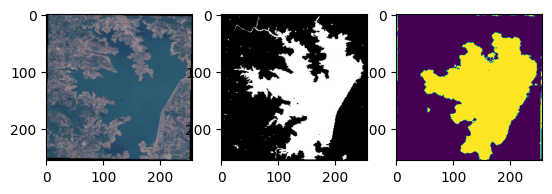

Epochs:4
Train_loss --> Dice: 0.2496426895260811 BCE: 0.3171545255929232 
Valid_loss --> Dice: 0.2510507371690538 BCE: 0.30379848347769844
Model Saved


100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


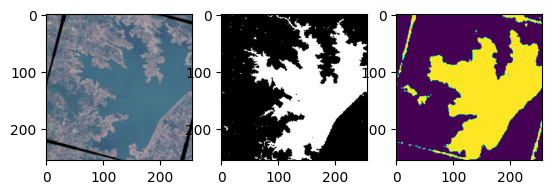

Epochs:5
Train_loss --> Dice: 0.2353895738720894 BCE: 0.30247492529451847 
Valid_loss --> Dice: 0.24305310514238146 BCE: 0.29502636028660667
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


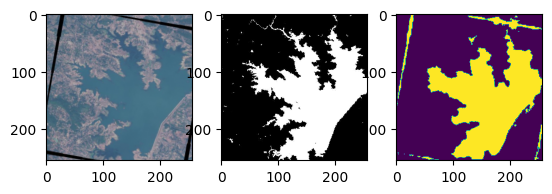

Epochs:6
Train_loss --> Dice: 0.2229549027979374 BCE: 0.28995447643101213 
Valid_loss --> Dice: 0.23002564244800144 BCE: 0.281910702586174
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


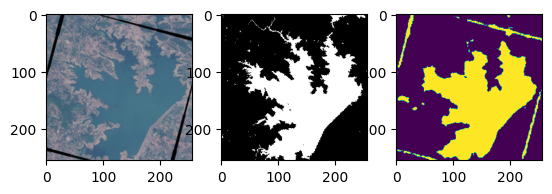

Epochs:7
Train_loss --> Dice: 0.21402303278446197 BCE: 0.2822169752791524 
Valid_loss --> Dice: 0.22390787469016182 BCE: 0.2768828123807907
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


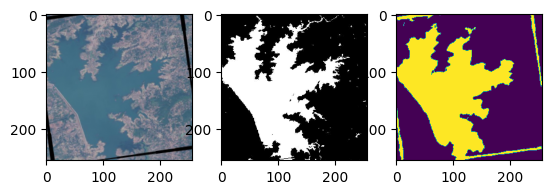

Epochs:8
Train_loss --> Dice: 0.20642000585794448 BCE: 0.2736466063186526 
Valid_loss --> Dice: 0.21851427025265163 BCE: 0.27868562936782837
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


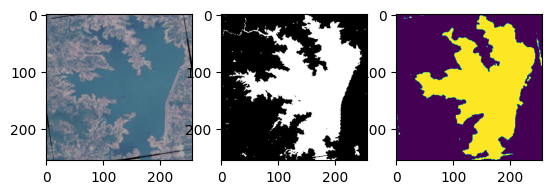

Epochs:9
Train_loss --> Dice: 0.20379589796066283 BCE: 0.2716373445466161 
Valid_loss --> Dice: 0.21774843666288587 BCE: 0.27305039597882164
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


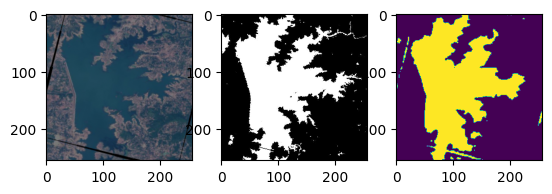

Epochs:10
Train_loss --> Dice: 0.19730257168412207 BCE: 0.26098843310028313 
Valid_loss --> Dice: 0.20706868833965725 BCE: 0.2612164351675246
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


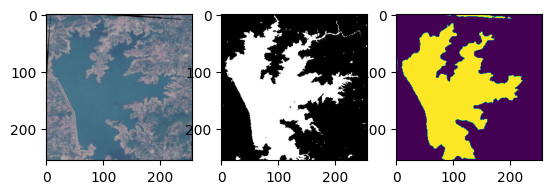

Epochs:11
Train_loss --> Dice: 0.18836235776543617 BCE: 0.2539428934454918 
Valid_loss --> Dice: 0.21033922831217447 BCE: 0.27279050482643974


100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


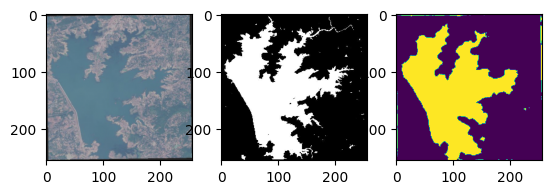

Epochs:12
Train_loss --> Dice: 0.1850479304790497 BCE: 0.24674262963235377 
Valid_loss --> Dice: 0.20103606912824842 BCE: 0.26008574499024284
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.54it/s]


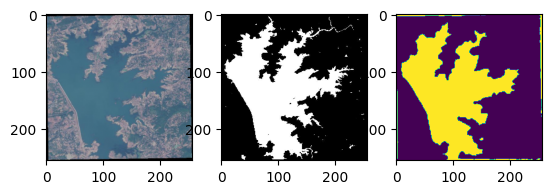

Epochs:13
Train_loss --> Dice: 0.1844419151544571 BCE: 0.2473661234602332 
Valid_loss --> Dice: 0.2029578553305732 BCE: 0.2600438760386573
Model Saved


100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


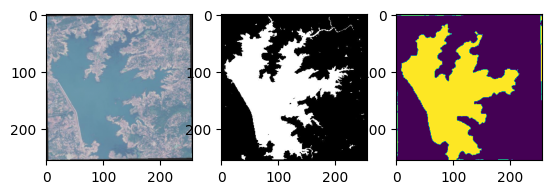

Epochs:14
Train_loss --> Dice: 0.1796104282140732 BCE: 0.23950317613780497 
Valid_loss --> Dice: 0.20013418462541369 BCE: 0.26559364795684814
Model Saved


100%|██████████| 9/9 [00:03<00:00,  2.54it/s]


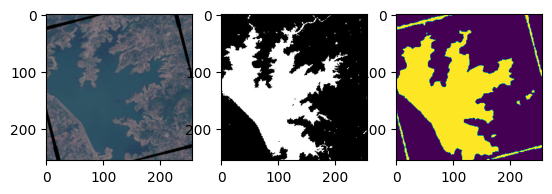

Epochs:15
Train_loss --> Dice: 0.17555391788482666 BCE: 0.2356251573190093 
Valid_loss --> Dice: 0.20294676886664498 BCE: 0.26988941099908614


In [22]:
#Dont run this
# To check the working, execute every cell apart from this one. (This is the training so will take lot of time)

best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)

    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss

    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')

    # Check if the current validation losses are better than the previous best
    
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        

        # For Running Locally
        torch.save(model.state_dict(),'hydrolens_best_model.pt')

        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

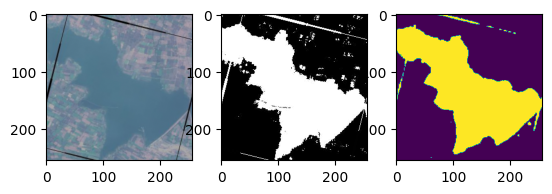

In [23]:
num=10 # Change for other images in the dataset (Choose number between 0 and 32(excluded))
ratio=0.5


model.load_state_dict(torch.load('/kaggle/working/hydrolens_best_model.pt'))



image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]

logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0)) # Perform a forward pass through the model to obtain the predicted mask

# Applies the sigmoid activation function to the logits to obtain predicted probabilities and converts it into binary predictions by thresholding with the specified ratio.

pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

# Creates a subplot with three images: the ground truth mask (axarr[1]), the original image (axarr[0]), and the predicted mask (axarr[2]).

f, axarr = plt.subplots(1,3)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))

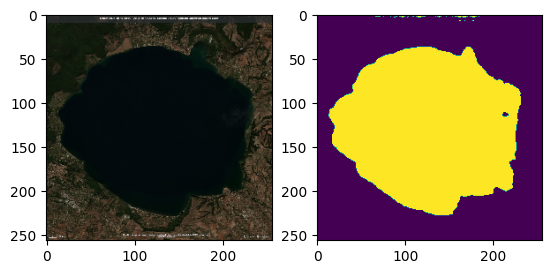

In [84]:
#Dont run
from PIL import Image
import torchvision.transforms as transforms

# Load your single satellite image
#image_path = '/content/drive/MyDrive/fyp/Satellite images/3/2023-10-25-00_00_2023-10-25-23_59_Sentinel-2_L2A_Highlight_Optimized_Natural_Color.jpg'
image_path = '/content/drive/MyDrive/fyp/Satellite images/1/2023-10-17-00_00_2023-10-17-23_59_Sentinel-2_L2A_True_color.jpg'
image = Image.open(image_path)

# Apply the same transformations used during training
transform = A.Compose([
     A.Resize(height,width),
     #Add any other transformations here
])

image = transform(image=np.array(image))['image']
image = np.transpose(image, (2, 0, 1)) / 255.0
image = torch.tensor(image).unsqueeze(0).to(DEVICE, dtype=torch.float32)

# Make a prediction
model.eval()
with torch.no_grad():
    logits = model(image)
    pred_mask = torch.sigmoid(logits)
    pred_mask = (pred_mask > ratio).float()

# Visualize the results

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))

# Ensure pred_mask has the correct shape before visualization
pred_mask_np = pred_mask.squeeze().cpu().numpy()
if pred_mask_np.shape[-1] == 1:
    pred_mask_np = pred_mask_np.squeeze(-1)  # Remove the singleton channel dimension if present

axarr[1].imshow(pred_mask_np)
plt.show()

output_mask = Image.fromarray((pred_mask_np * 255).astype(np.uint8))
output_mask.save('/content/drive/MyDrive/fyp/predicted_mask.png')

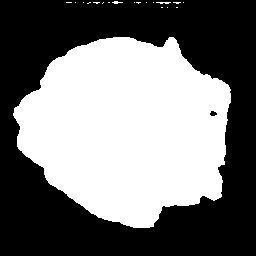

Area per pixel:  0.0006103515625

Water Surface area =  55.6329345703125  km sq


In [86]:
#Dont run
img = cv2.imread("/content/drive/MyDrive/fyp/predicted_mask.png") # Reading the predicted mask
cv2_imshow(img) # Displaying the predicted mask

white_pix = np.sum(img == 255) # Counting the number of white pixels
black_pix = np.sum(img == 0) # Counting the number of black pixels

total_pix = black_pix + white_pix 

img_irl_area=120 # Area in sq km of the actual image.

area_per_pix = img_irl_area / total_pix # Calculating the area per pixel

print("Area per pixel: ",area_per_pix)

water_surface_area = white_pix * area_per_pix # Computing the water surface area
print("Water Surface area = ",water_surface_area," km sq")

In [27]:
len(X_val)
len(y_val)

285

In [49]:
#Predicted masks for X_val set
from PIL import Image
import torchvision.transforms as transforms
for num in range(0,284):
    image_path = X_val[num]
    image = Image.open(image_path)

    # Apply the same transformations used during training
    transform = A.Compose([
         A.Resize(height,width),
         #Add any other transformations here
    ])

    image = transform(image=np.array(image))['image']
    image = np.transpose(image, (2, 0, 1)) / 255.0
    image = torch.tensor(image).unsqueeze(0).to(DEVICE, dtype=torch.float32)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        logits = model(image)
        pred_mask = torch.sigmoid(logits)
        pred_mask = (pred_mask > ratio).float()
    
    pred_mask_np = pred_mask.squeeze().cpu().numpy()
    if pred_mask_np.shape[-1] == 1:
        pred_mask_np = pred_mask_np.squeeze(-1)
    output_mask = Image.fromarray((pred_mask_np * 255).astype(np.uint8))
    output_mask.save('/kaggle/working/outputmask_'+str(num)+'.jpg')
'''
    # Visualize the results

    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))

    # Ensure pred_mask has the correct shape before visualization
    

    axarr[1].imshow(pred_mask_np)
    plt.show()
'''


'\n    # Visualize the results\n\n    f, axarr = plt.subplots(1, 2)\n    axarr[0].imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))\n\n    # Ensure pred_mask has the correct shape before visualization\n    \n\n    axarr[1].imshow(pred_mask_np)\n    plt.show()\n'

In [111]:
#Accuracy of the segmentation model
from PIL import Image
import numpy as np


def resize_image(imagepath, target_size=(256, 256)):
    image = Image.open(imagepath)
    resized_image = image.resize(target_size)
    arr = np.array(resized_image)
    return resized_image

def convert_to_grayscale(image):
    return image.convert("L")  # Convert to grayscale

def calculate_pixel_similarity(image1, image2):
    array1 = np.array(image1)
    array2 = np.array(image2)
   
    # Normalize pixel values to [0, 1]
    normalized_array1 = array1 / 255.0
    normalized_array2 = array2 / 255.0

    # Convert to grayscale if the images are RGB
    if array1.shape[2] == 3:
        normalized_array1 = np.array(convert_to_grayscale(Image.fromarray((normalized_array1 * 255).astype(np.uint8))))
        normalized_array2 = np.array(convert_to_grayscale(Image.fromarray((normalized_array2 * 255).astype(np.uint8))))
    
    # Normalize pixel values to [0, 1]
    normalized_array1 = normalized_array1 / 255.0
    normalized_array2 = normalized_array2 / 255.0      

    # Calculate pixel-wise difference
    pixel_difference = np.abs(normalized_array1 - normalized_array2)

    # Calculate mean difference over all pixels
    mean_diff = np.mean(pixel_difference)

    similarity_percentage = 1 - mean_diff
    return similarity_percentage * 100

target_size = (256, 256)
percents =[]
for num in range(285):
    image_path = y_val[num]
    masked_image_path = '/kaggle/working/outputmask_' + str(num) + '.jpg'

    # Resize images
    resized_image = resize_image(image_path, target_size)
    resized_masked_image = resize_image(masked_image_path, target_size)

    # Calculate pixel-wise similarity
    similarity_percentage = calculate_pixel_similarity(resized_image, resized_masked_image)
    percents.append(float(similarity_percentage))
mean = sum(percents)/len(percents)
print(f"The accuracy of the model is {mean:.2f}%")


The accuracy of the model is 90.37%
